In [4]:
import pandas as pd
import os
import random
import gensim.models.doc2vec

from gensim.models.doc2vec import Doc2Vec

def load_data(path):
    df = pd.read_csv(path)
    df.head()
    return df

In [5]:
df = load_data('../bostonGlobe/bostonglobe2014.csv')

In [6]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–", "\xc2", "\xa0",
             "\x80", "\x9c", "\x99", "\x94", "\xad", "\xe2", "\x9d"]

for char in spec_chars:
    df['text'] = df['text'].str.replace(char, ' ')

<ipython-input-6-791ff3e3d1d4>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace(char, ' ')


In [7]:
def tokenize(text, stopwords, max_len = 20):
    return [token for token in gensim.utils.simple_preprocess(text, max_len=max_len) if token not in stopwords]

In [8]:
articles = df.values.tolist()
articles_flat = [item for sublist in articles for item in sublist]
tagged_docs = [gensim.models.doc2vec.TaggedDocument(tokenize(text, [], max_len=200), [i]) for i, text in enumerate(articles_flat)]

In [9]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, epochs=40, window=2, dm=1)
model.build_vocab(tagged_docs)
model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)

In [10]:
vector = model.infer_vector(['black', 'african american', 'african-american', 'haitian', 'jamaican', 'west indian', 'dominican'])

#print(vector)

In [11]:
def pick_random_word(model, threshold=10):
    # pick a random word with a suitable number of occurences
    while True:
        word = random.choice(model.wv.index_to_key)
        if model.wv.get_vecattr(word, "count") > threshold:
            return word

#target_word = pick_random_word(model)
# or uncomment below line, to just pick a word from the relevant domain:
target_word = ['black', 'haitian', 'jamaican', 'dominican']

diction = {}

for w in target_word:
    print(f'target_word: {repr(w)} model: {model} similar words:')
    for i, (word, sim) in enumerate(model.wv.most_similar(w, topn=15), 1):
        diction[sim] = word
        print(f'    {i}. {sim:.2f} {repr(word)}')
    print()

target_word: 'black' model: Doc2Vec(dm/m,d30,n5,w2,mc5,s0.001,t3) similar words:
    1. 0.78 'latino'
    2. 0.74 'vietnamese'
    3. 0.73 'muslim'
    4. 0.72 'transgender'
    5. 0.72 'minority'
    6. 0.71 'disabled'
    7. 0.71 'masked'
    8. 0.70 'hispanic'
    9. 0.70 'liberian'
    10. 0.69 'young'
    11. 0.69 'asian'
    12. 0.68 'ethnic'
    13. 0.68 'white'
    14. 0.67 'grieving'
    15. 0.67 'dominican'

target_word: 'haitian' model: Doc2Vec(dm/m,d30,n5,w2,mc5,s0.001,t3) similar words:
    1. 0.75 'asian'
    2. 0.74 'japanese'
    3. 0.70 'american'
    4. 0.69 'pygmy'
    5. 0.68 'lu'
    6. 0.67 'african'
    7. 0.67 'chinese'
    8. 0.67 'diaspora'
    9. 0.65 'liberian'
    10. 0.65 'vietnamese'
    11. 0.65 'captive'
    12. 0.64 'northern'
    13. 0.64 'wealthy'
    14. 0.64 'irish'
    15. 0.63 'dominican'

target_word: 'jamaican' model: Doc2Vec(dm/m,d30,n5,w2,mc5,s0.001,t3) similar words:
    1. 0.72 'moderate'
    2. 0.67 'marble'
    3. 0.65 'spicy'
    4. 0.64

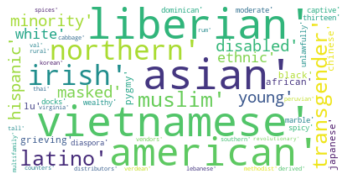

In [12]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
'''from pandas import DataFrame
df = DataFrame (words,columns=['keywords'])'''
diction = str(diction)
text = diction
#print(words)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("../img/word_cloud.png")

In [13]:
def compute_similar_words(model,source_word, topn=5):
    ''' For the given the source word, capture all the topn words'''
    print('\r Computing similar words for the source word - {0:35s}'.format(source_word),end='')

    similar_words = [source_word]
    
    try:
        top_words = model.wv.most_similar(source_word,topn=topn)
        similar_words.extend([val[0] for val in top_words])
    except KeyError as err:
        print(err.args)

    return similar_words    

In [15]:

keywords = ['black', 'haitian', 'jamaican', 'dominican']
def compute_similar_words_for_all_tasks(model,topn=5):
    '''For all the words provided in the keyword list, capture the topn similar words'''
    
    columns = ['word'+str(i-1) for i in range(1,topn+2)]

    df = pd.DataFrame(data=None,columns=columns)
    
    for source_word in keywords:
        similar_words = compute_similar_words(model,source_word,topn)
        df.loc[len(df)] = similar_words
        
        for i in range(1,len(similar_words)):
            sec_similar_words = compute_similar_words(model,similar_words[i],topn)
            df.loc[len(df)] = sec_similar_words

    df.to_csv('similar_words_task1.csv')

In [16]:
compute_similar_words_for_all_tasks(model)

 Computing similar words for the source word - korean                             

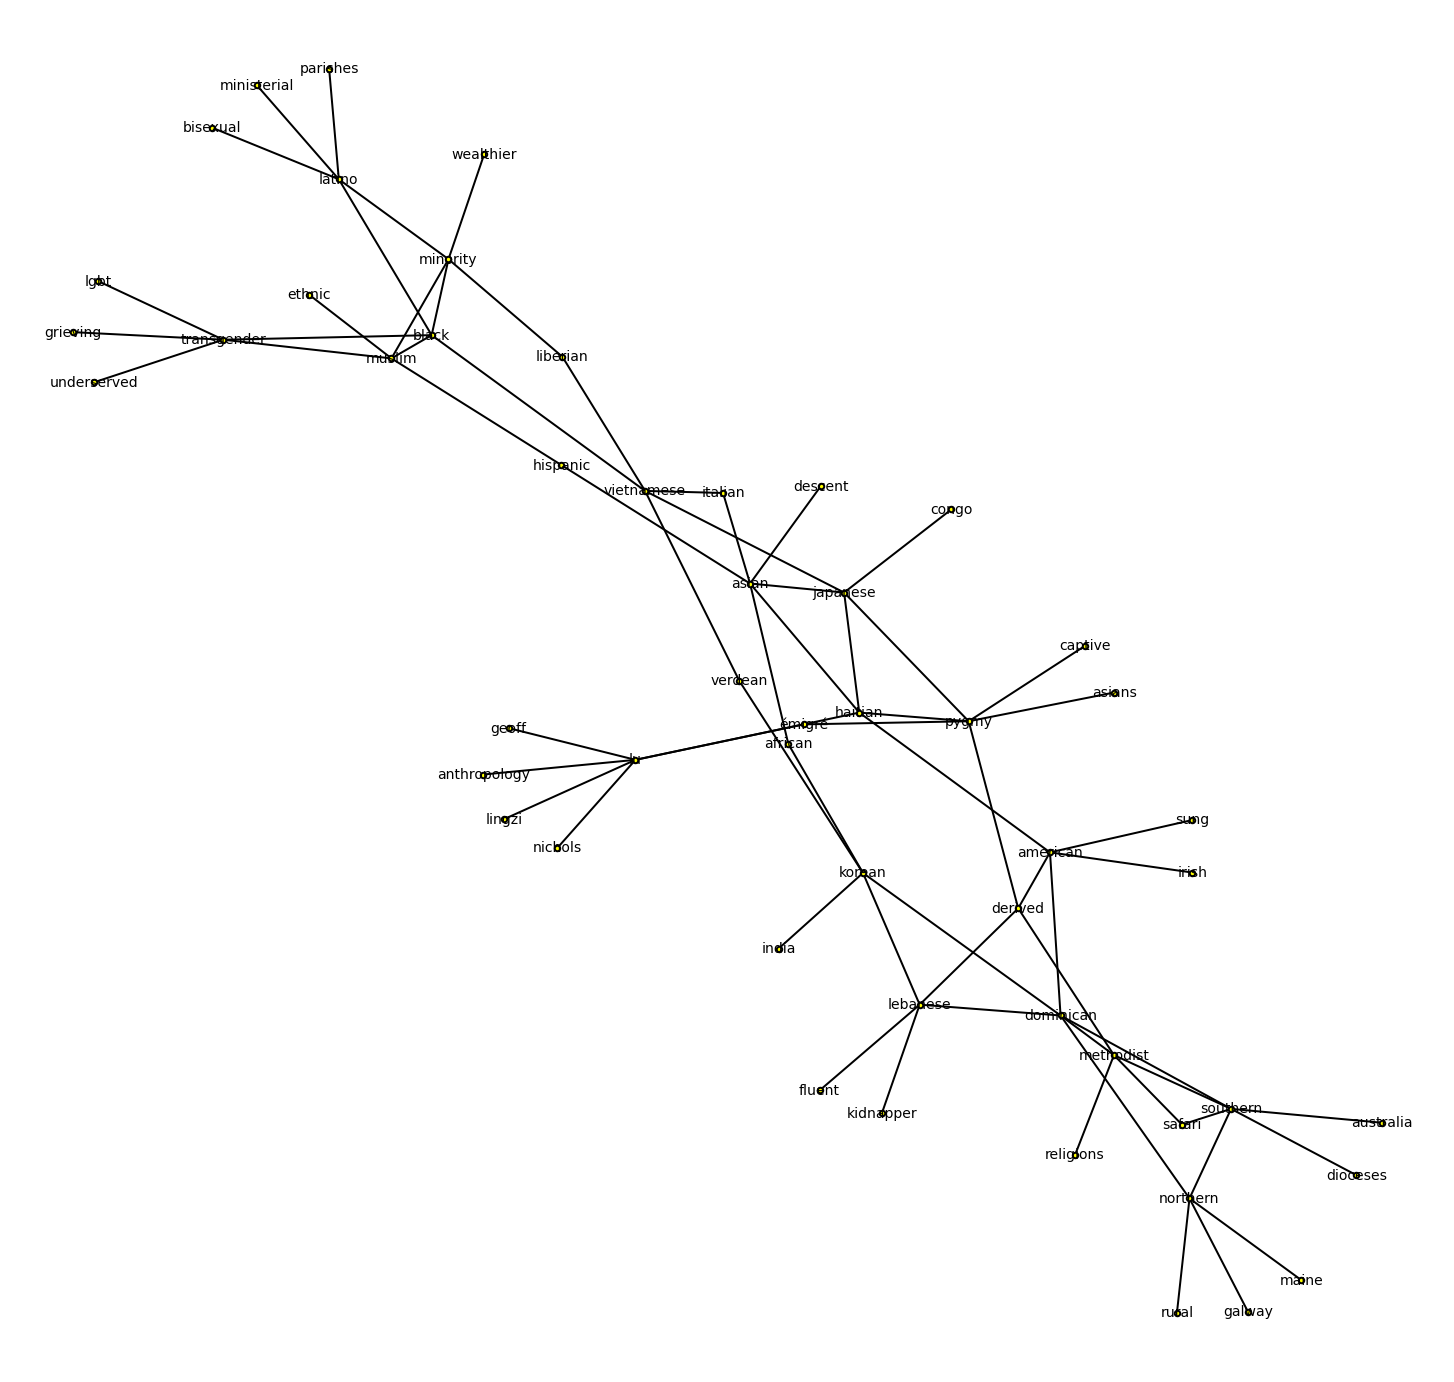

In [17]:
import networkx as nx



words = pd.read_csv('similar_words_task1.csv')
g = nx.Graph()

j = 1
for i, row in words.iterrows():
    for j in range(1,len(row)):
        g.add_node(i,label=row[j])
    for j in range(1,len(row)):
        g.add_edge(row[1], row[j])    


plt.rcParams["figure.figsize"] = 20,19

options = {
    "font_size": 14,
    "node_size": 30,
    "node_color": "yellow",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}

subgraph = nx.node_connected_component(g,'black')
nx.draw(g.subgraph(subgraph), with_labels=True, **options)

    #nx.write_graphml(g.subgraph(subgraph), "results.graphml")
plt.show()

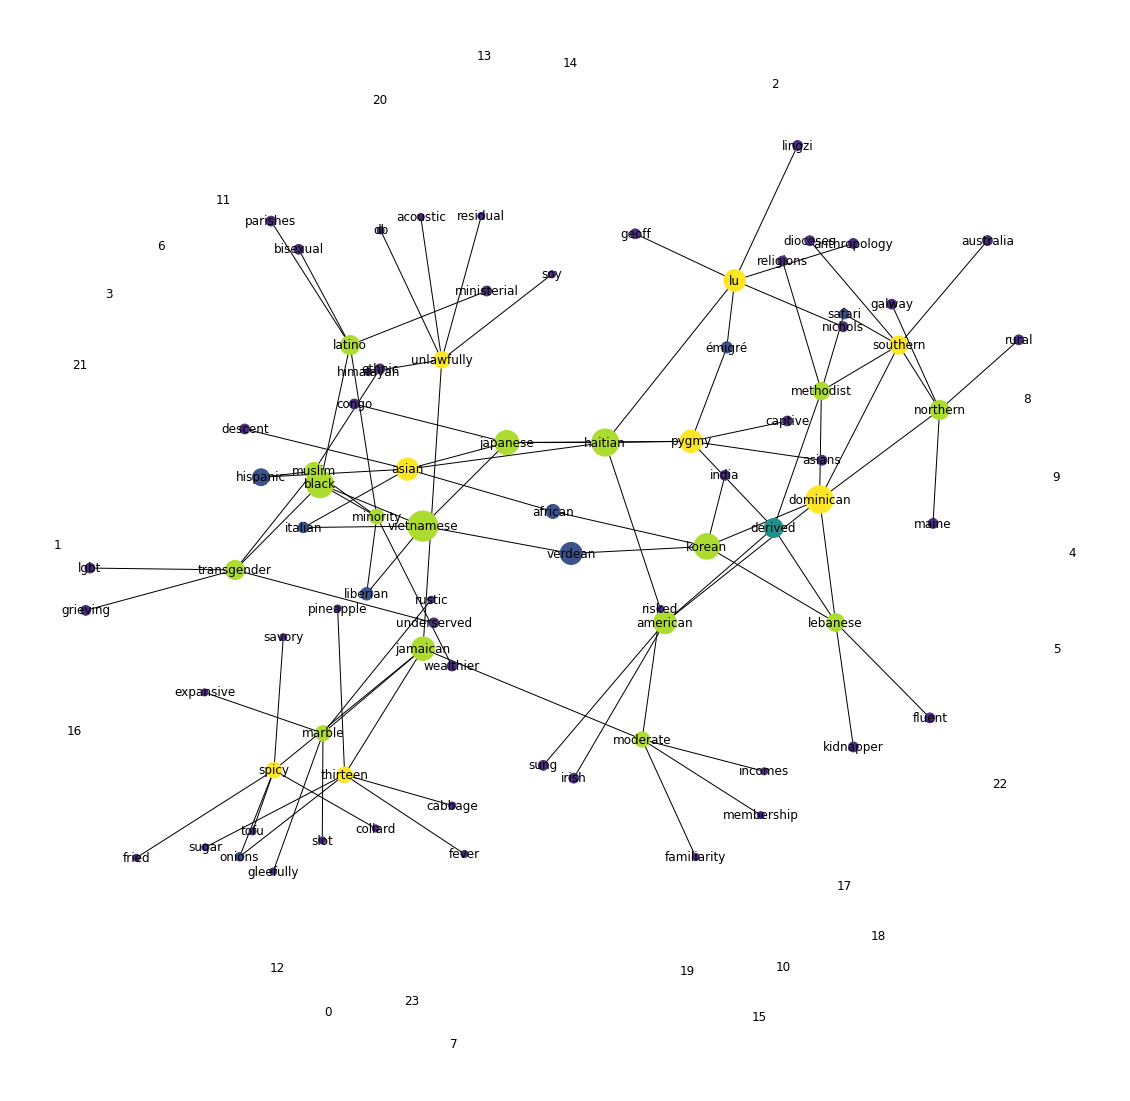

In [18]:
pos = nx.spring_layout(g,k=0.3)
betCent = nx.betweenness_centrality(g, normalized=True, endpoints=True)
node_color = [20000.0 * g.degree(v) for v in g]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(g, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')
plt.savefig("../img/network-graph.png")